# Установка библиотек

In [1]:
# !pip install hazardous@git+https://github.com/soda-inria/hazardous
# !pip install pycox
# !pip install scikit-survival
# !pip install numba --user

In [2]:
from functools import reduce
# from hazardous import SurvivalBoost
# from hazardous.metrics import integrated_brier_score_survival, integrated_brier_score_incidence
from lifelines import AalenJohansenFitter
from lifelines import CoxPHFitter
# from lifelines.utils import concordance_index
# from pycox.evaluation import EvalSurv
from pycox.models import DeepHit
from pycox.preprocessing.label_transforms import LabTransDiscreteTime
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
# from sksurv.metrics import check_y_survival, CensoringDistributionEstimator
# from sksurv.metrics import cumulative_dynamic_auc
# from sksurv.util import Surv
from typing import List
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# Подготовка данных

In [3]:
warnings.filterwarnings('ignore')

In [4]:
dtypes = {'credit_score': 'Int16', 'first_payment_date': 'str', 'first_time_homebuyer_flag': 'str',
        'maturity_date': 'str', 'MSA': 'Int32', 'MI_%': 'Int16', 'units_numb': 'Int8', 'occupancy_status': 'str',
        'CLTV': 'Int16', 'DTI_ratio': 'Int16', 'orig_UPB': 'Int64', 'LTV': 'Int16', 'orig_interest_rate': 'str',
        'channel': 'str', 'PPM_flag': 'str', 'amortization_type': 'str',
        'property_state': 'str', 'property_type': 'str', 'postal_code': 'Int32', 'id_loan': 'str',
        'loan_purpose': 'str', 'orig_loan_term': 'Int16', 'borrowers_num': 'Int8', 'seller_name': 'str',
        'service_name': 'str', 'super_conf_flag': 'str', 'id_loan_preharp': 'str',
        'program_ind': 'str', 'HARP_ind': 'str', 'property_val_method': 'Int64',
        'int_only_flag': 'str', 'MI_cancel_flag': 'str', 'orig_interest_rate':'float32'}

static = ['credit_score', 'first_time_homebuyer_flag', 'units_numb', 'MSA', 'MI_%', 'occupancy_status', 'CLTV', 'DTI_ratio', 'orig_UPB',
       'LTV', 'orig_interest_rate', 'channel', 'PPM_flag', 'amortization_type',
       'property_state', 'property_type', 'loan_purpose', 'orig_loan_term', 'borrowers_num', 'super_conf_flag',
       'int_only_flag', 'property_val_method']

categ = ['occupancy_status', 'first_time_homebuyer_flag', 'channel', 'PPM_flag', 'amortization_type',
       'property_state', 'borrowers_num', 'int_only_flag', 'property_val_method', 'modification_flag', 'step_mod_flag', 'deferred_payment_plan',
         'ELTV', 'delinq_due_disaster', 'borrowe_asistance_stat_code', 'property_type', 'loan_purpose', 'super_conf_flag']

def get_y(cens, time):
    cens, time = np.array(cens), np.array(time)
    y = np.empty(dtype=[('event', int), ('duration', np.float64)], shape=cens.shape[0])
    y['event'] = cens
    y['duration'] = time
    return y

def get_y_arr(y):
    cens, time = np.array(y.event), np.array(y.duration)
    y = np.empty(dtype=[('event', bool), ('duration', np.float64)], shape=cens.shape[0])
    y['event'] = cens
    y['duration'] = time
    return y


def get_y_event(y_, events: List=[]):
    y = np.empty(dtype=[('event', bool), ('duration', np.float64)], shape=y_.shape[0])
    y['event'] = y_.event.isin(events)
    y['duration'] = y_.duration
    return y

def case1(X_, y_, events: List=[]):
    y, X = y_.copy(), X_.copy()
    mask = y_.event.isin(events)
    y.event = mask.astype('int')
    return X, y

def case2(X_, y_, events: List=[]):
    y, X = y_.copy(), X_.copy()
    mask = y_.event.isin(events)
    y.event = mask
    y = y[mask]
    X = X[mask]
    return X, y

def case3(X_, y_, events: List=[], ):
    y, X = y_.copy(), X_.copy()
    mask = y_.event.isin(events)
    maxm = y_.duration[mask].max()
    y.event = mask
    X = X[y.duration<=maxm]
    y = y[y.duration<=maxm]
    return X, y
    
    

def transform_timegrid(curves, time, grid):
    if time.max() < grid.max():
        time = np.hstack([time, np.array([grid.max()+1])])
        if len(curves.shape)==1:
            curves = np.hstack([curves, np.array([0])])
        elif len(curves.shape)==2:
            curves = np.hstack([curves, np.zeros(shape=(curves.shape[0], 1))])
    ind = np.searchsorted(time, grid)
    if len(curves.shape)==1:
      return curves[ind]
    elif len(curves.shape)==2:
      return curves[:, ind]
    else:
      return None


def transform_curves(curves): # noninc
  """
    - curves - current survvial_function(s)
    -------
    Returns:
    - array of nonincreasing survival function(s)
  """
  if len(curves.shape) == 1: curves = curves[None, :]
  return np.array(list(map(lambda tmp:
                           reduce(lambda c, x: (c[0], c[1]+[c[0]])
                           if x > c[0] else (x, c[1]+[x]),
                           tmp[1:], (tmp[0], [tmp[0]]))[1],
                       curves)))

def transform_events(y):
  events = sorted(y.event.unique())
  d = {events[i]:i for i in range(len(events))}
  return y.replace({"event": d}), d

def step_to_array(step_functions):
    shape_=(step_functions.shape[0], step_functions[0].x.shape[0])
    arr = np.empty(shape=shape_)
    for i in range(len(step_functions)):
        arr[i] = step_functions[i].y
    return arr, step_functions[0].x


def str_to_categ(df_col):
    uniq = df_col.unique()
    return df_col.map(dict(zip(uniq, range(len(uniq)))))

def column_transformer(X):
    X.MSA.fillna(X.MSA.median(), inplace=True)
    constant_cols=['int_only_flag', 'property_val_method', 'super_conf_flag', 'amortization_type']
    categs = list((set(static) & set(categ) - set(constant_cols)))
    dct = {col: sorted(X[col].unique()) for col in categs}
                  
    X.drop(constant_cols, inplace=True, axis=1)
    enc = ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse_output=False).set_output(transform="pandas"), categs)], remainder='passthrough')
    X = enc.fit_transform(X)
    scaler = StandardScaler().set_output(transform="pandas")
    X = scaler.fit_transform(X)
    return X #pd.DataFrame(X, columns=scaler.feature_names_in_)



def calc_short():
    file = r"./data/result_short.csv"
    df = pd.read_csv(file, dtype=dtypes)
    df['event'] = df.zero_balance_code.astype('int')*(df.cens.astype('int'))
    df = df[static+['time', 'event']]
    df = df.apply(lambda x: str_to_categ(x) if x.name in categ else x, axis=0)
    sign = sorted(list(set(df.columns) - {'time', 'event'}))
    y = get_y(df['event'], df['time'] + 1)
    X = df.loc[:, sign]
    return y, X, sign, categ, df

In [5]:
categs = list(set(static) & set(categ))


In [6]:
y, X, sign, categ, df = calc_short()
X = column_transformer(X)

In [7]:
y_ = pd.DataFrame(y)
y_, dct = transform_events(y_)
x_train, x_test, y_train, y_test = train_test_split(X, y_, test_size=0.2, stratify=y_.event, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train.event, random_state = 1)

TIME_GRID = np.linspace(y_train['duration'].min(), y_train['duration'].max(), 100)

<Axes: xlabel='duration', ylabel='Density'>

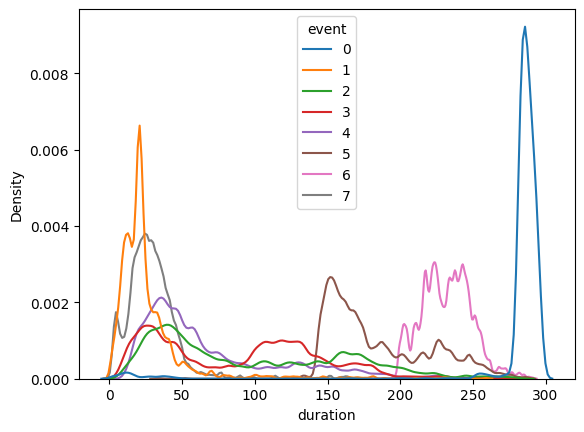

In [8]:
sns.kdeplot(data=y_train, x="duration", hue="event", bw_adjust=0.25, palette="tab10")

## Анализ событий

In [9]:
df.groupby(by='event').time.agg(['min', 
                                    ('Q1', lambda x: np.quantile(x, 0.25)),
                                    ('Q2', lambda x: np.quantile(x, 0.5)),
                                    ('Q3', lambda x: np.quantile(x, 0.75)),
                                    'max'])
# количество у всех одинаковое - 3000

,min,Q1,Q2,Q3,max
event,,,,,
0,1,283.00,286.0,290.0,296
1,0,12.00,19.0,29.0,287
2,6,40.75,78.0,156.0,285
3,4,34.00,95.0,128.0,281
9,7,33.00,50.0,90.0,289
15,33,155.00,171.0,212.0,286
16,178,218.00,231.0,242.0,290
96,0,17.00,26.0,35.0,276


# Модели

## AalenJohansenFitter (lifelines)



ibs 1 :   0.2223
ibs 9 :   0.2035
ibs 96:   0.2213
ibs 16:   0.0996
ibs 3 :   0.1942
ibs 2 :   0.1917
ibs 15:   0.1401


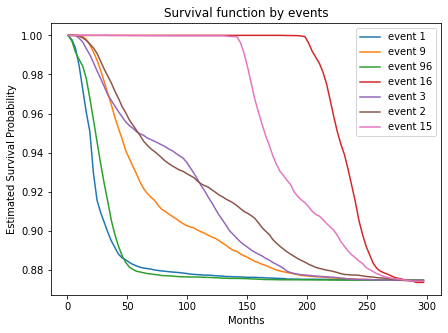

In [450]:
aj = AalenJohansenFitter()
fig, ax = plt.subplots(figsize=(7, 5))
T, E = y_.duration, y_.event
for i in df.event.unique():
  if i:
    aj.fit(T, E, event_of_interest=dct[i])
    curve = 1-aj.cumulative_density_[f'CIF_{dct[i]}']
    new_curve = transform_timegrid(curve.values, aj.cumulative_density_.index, TIME_GRID).T.astype(float)
    
    #ibs of model with new time_grid
    
    ibs_ = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      np.repeat(new_curve[np.newaxis, :], y_test.shape[0], axis=0),
                      times=TIME_GRID, axis=-1)
    print(f"ibs {i:<2}:   {ibs_:<4.4f}")
    ax.plot(TIME_GRID,
                new_curve,
                label=f"event {i}")
ax.legend()
ax.set_title(f"Survival function by events")
ax.set_xlabel("Months")
ax.set_ylabel("Estimated Survival Probability")
plt.show()
    

## SurvivalBoost (hazardous)

In [94]:
survival_boost = SurvivalBoost(show_progressbar=True).fit(x_train, y_train)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.95it/s]


1. **predict_survival_function** - предсказывает вероятность ненаступления любого из событий (т.е. функция выживания для любого события). Вычисляется на основе (2): predict_cumulative_incidence[:, 0, :]
2.**predict_cumulative_incidence** - кумулятивная функция риска для каждого типа событий, возвращает массив (n_samples, n_events + 1, n_times):
    *  array[:, 0, :] - вероятность отсутствия события( функция выживания для любого события (формула (*)))
    *   array[:, i, :] - cif_i, i=(0, 1, 2, 3, 9, 15, 16, 96)



(*) $$ S(t) = 1 - \sum_{k} cif_k$$

#### **predict_cumulative_incidence**

In [213]:
cif_sb = survival_boost.predict_cumulative_incidence(x_test, times=TIME_GRID)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.62it/s]


In [429]:
cif_sb.shape

(4800, 8, 100)

Text(0, 0.5, 'Estimated Survival Probability')

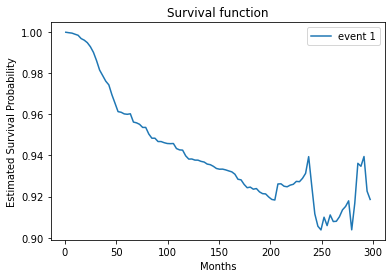

In [437]:
fig, axs = plt.subplots(figsize=(6, 4))
axs.plot(TIME_GRID, 1-cif_sb[0][2], label=(f"event 1"))
axs.legend()
axs.set_title(f"Survival function")
axs.set_xlabel("Months")
axs.set_ylabel("Estimated Survival Probability")
#plt.plot(1-cif_sb[0][1])

In [55]:
x_train.columns

Index(['CLTV', 'DTI_ratio', 'LTV', 'MI_%', 'MSA', 'PPM_flag',
       'amortization_type', 'borrowers_num', 'channel', 'credit_score',
       'first_time_homebuyer_flag', 'int_only_flag', 'loan_purpose',
       'occupancy_status', 'orig_UPB', 'orig_interest_rate', 'orig_loan_term',
       'property_state', 'property_type', 'property_val_method',
       'super_conf_flag', 'units_numb'],
      dtype='object')

        noninc       old
ibs 1 :   0.0896     0.0918
ibs 2 :   0.1643     0.1685
ibs 3 :   0.1432     0.1474
ibs 9 :   0.1370     0.1403
ibs 15:   0.0667     0.0677
ibs 16:   0.0767     0.0792
ibs 96:   0.1568     0.1635


Text(0, 0.5, 'Estimated Survival Probability')

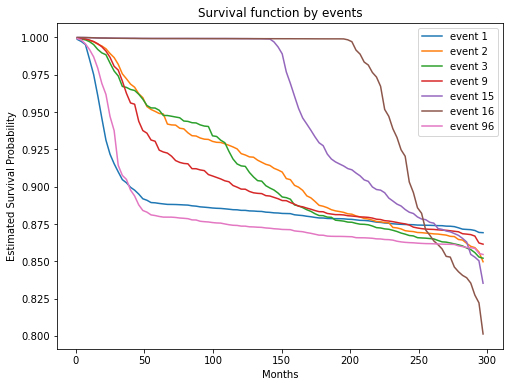

In [452]:
fig, axs = plt.subplots(figsize=(8, 6))
print('        noninc       old')
for i in sorted(df.event.unique()):
  if i:
    sf = 1-cif_sb[:, dct[i], :]
    #sf = transform_timegrid(sf, survival_boost.time_grid_, TIME_GRID)
    ibs_old =  ibs_remain(get_y_event(y_train, [dct[i]]),
                       get_y_event(y_test, [dct[i]]), sf,
                       times=TIME_GRID, axis=-1)
    sf = transform_curves(sf)
    ibs =  ibs_remain(get_y_event(y_train, [dct[i]]),
                       get_y_event(y_test, [dct[i]]), sf,
                       times=TIME_GRID, axis=-1)
    print(f"ibs {i:<2}:   {ibs:<4.4f}     {ibs_old:<4.4f}")
    axs.plot(TIME_GRID, sf.mean(axis=0), label=(f"event {i}"))
axs.legend()
axs.set_title(f"Survival function by events")
axs.set_xlabel("Months")
axs.set_ylabel("Estimated Survival Probability")

#### **predict_survival_function**

        old time_grid      new time_grid
ibs 1 :   0.06                 0.06    
ibs 9 :   0.07                 0.06    
ibs 96:   0.06                 0.06    
ibs 16:   0.08                 0.08    
ibs 3 :   0.07                 0.07    
ibs 2 :   0.08                 0.07    
ibs 15:   0.08                 0.08    
---------
 ibs: 0.06


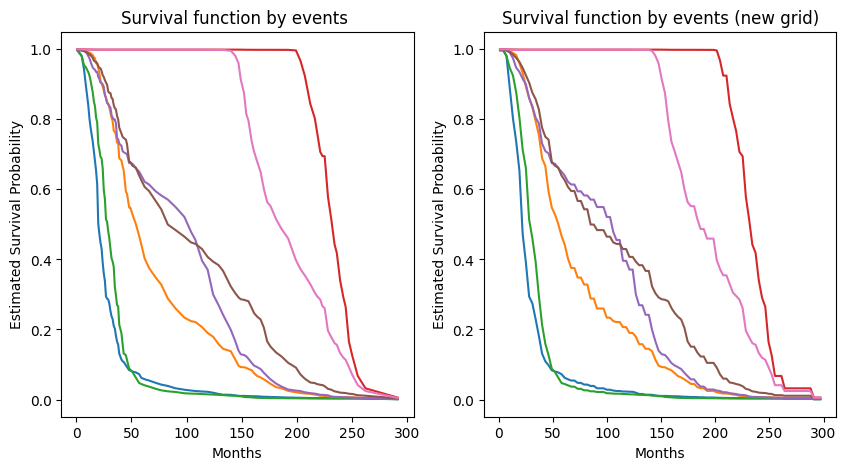

In [ ]:
curves = survival_boost.predict_survival_function(x_)
curves = transform_curves(curves)
curves_new = transform_timegrid(curves, survival_boost.time_grid_, TIME_GRID)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
scores=[]
print('        old time_grid      new time_grid')
for i in df.event.unique():
  if i:
    mask = y_test["event"] == dct[i]
    mean_survival = curves[mask].mean(axis=0)
    sf = transform_timegrid(mean_survival, survival_boost.time_grid_, TIME_GRID)
    sf = transform_curves(sf)

    ibs_1 = ibs_remain(get_y_event(y_train, [dct[i]]),
                       get_y_event(y_test, [dct[i]]), curves,
                       times=survival_boost.time_grid_, axis=-1)

    ibs_2 = ibs_remain(get_y_event(y_train, [dct[i]]),
                       get_y_event(y_test, [dct[i]]), curves_new,
                       times=TIME_GRID, axis=-1)
    print(f"ibs {ev:<2}:   {ibs_1:<4.2f}                 {ibs_2:<8.2f}")

    #scores.append(ibs_)
    #print(f"ibs {ev}: {ibs_}")
    axs[0].plot(
        survival_boost.time_grid_,
        mean_survival,
        label=(f"event {i}"),
    )

    axs[1].plot(TIME_GRID, sf, label=(f"event {ev}"))
# ibs_ = ibs_remain(get_y_event(y_train, sorted(df.event.unique())[1:]),
#                   get_y_event(y_test, sorted(df.event.unique())[1:]), curves_new, times=TIME_GRID, axis=-1)
# scores.append(ibs_)
# print('---------\n', f"ibs: {ibs_:.2f}")
# ibs['SurvivalBoost']=scores
for i in (0, 1):
  axs[i].set_title(f"Survival function by events {i*'(new grid)'}")
  axs[i].set_xlabel("Months")
  axs[i].set_ylabel("Estimated Survival Probability")

plt.show()

## DeepHit (pycox)

In [348]:
get_x = lambda df: (df.values.astype('float32'))
get_target = lambda df: (df['duration'].values, df['event'].values)


class LabTransform(LabTransDiscreteTime):
    def transform(self, durations, events):
        durations, is_event = super().transform(durations, events > 0)
        events[is_event == 0] = 0
        return durations, events.astype('int64')


class CauseSpecificNet(torch.nn.Module):
    """Network structure similar to the DeepHit paper, but without the residual
    connections (for simplicity).
    """
    def __init__(self, in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                 out_features, batch_norm=True, dropout=None):
        super().__init__()
        self.shared_net = tt.practical.MLPVanilla(
            in_features, num_nodes_shared[:-1], num_nodes_shared[-1],
            batch_norm, dropout,
        )
        self.risk_nets = torch.nn.ModuleList()
        for _ in range(num_risks):
            net = tt.practical.MLPVanilla(
                num_nodes_shared[-1], num_nodes_indiv, out_features,
                batch_norm, dropout,
            )
            self.risk_nets.append(net)

    def forward(self, input):
        out = self.shared_net(input)
        out = [net(out) for net in self.risk_nets]
        out = torch.stack(out, dim=1)
        return out

In [349]:
labtrans = LabTransform(100)
get_target = lambda df: (df['duration'].values, df['event'].values)

y_train_dh = labtrans.fit_transform(*get_target(y_train.sort_values(by='duration')))
y_val_dh = labtrans.transform(*get_target(y_val))
durations_test, events_test = get_target(y_test)
x_train_dh = get_x(x_train)
x_val_dh = get_x(x_val)
x_test_dh = get_x(x_test)
val = (x_val_dh, y_val_dh)
train = (x_train_dh, y_train_dh)

in_features = x_train_dh.shape[1]
num_nodes_shared = [64, 64]
num_nodes_indiv = [32]
num_risks = y_train_dh[1].max()
out_features = len(labtrans.cuts)
batch_norm = True
dropout = 0.1

# net = SimpleMLP(in_features, num_nodes_shared, num_risks, out_features)
net = CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                       out_features, batch_norm, dropout)
optimizer = tt.optim.AdamWR(lr=0.01, decoupled_weight_decay=0.01,
                            cycle_eta_multiplier=0.8)
model = DeepHit(net, optimizer, alpha=0.2, sigma=0.1,
                duration_index=labtrans.cuts)

In [325]:
# epochs = 512
# batch_size = 256
# callbacks = [tt.callbacks.EarlyStoppingCycle()]
# verbose = True
# log = model.fit(x_train_dh, y_train_dh, batch_size, epochs, callbacks, verbose, val_data=val)

0:	[1s / 1s],		train_loss: 1.5791,	val_loss: 1.5479
1:	[1s / 3s],		train_loss: 1.4582,	val_loss: 1.4624
2:	[1s / 4s],		train_loss: 1.4041,	val_loss: 1.4926
3:	[1s / 6s],		train_loss: 1.4025,	val_loss: 1.4573
4:	[1s / 8s],		train_loss: 1.3859,	val_loss: 1.4599
5:	[1s / 10s],		train_loss: 1.3675,	val_loss: 1.4638
6:	[1s / 11s],		train_loss: 1.3560,	val_loss: 1.4635
7:	[1s / 13s],		train_loss: 1.3747,	val_loss: 1.4718
8:	[1s / 15s],		train_loss: 1.3655,	val_loss: 1.4761
9:	[1s / 16s],		train_loss: 1.3543,	val_loss: 1.4766
10:	[1s / 18s],		train_loss: 1.3447,	val_loss: 1.4841
11:	[1s / 20s],		train_loss: 1.3334,	val_loss: 1.4840
12:	[1s / 21s],		train_loss: 1.3230,	val_loss: 1.4879
13:	[1s / 23s],		train_loss: 1.3153,	val_loss: 1.4890
14:	[1s / 25s],		train_loss: 1.3098,	val_loss: 1.4892
15:	[1s / 26s],		train_loss: 1.3334,	val_loss: 1.4991


In [366]:
import numpy as np
from sklearn.model_selection import ParameterSampler

N = 100
param_grid = {
    'batch_size': [128, 256, 512],
    'num_nodes_shared': [[64, 64], [128, 128], [256, 256]],
    'num_nodes_indiv': [[32], [64], [128]],
    'batch_norm': [True, False],
    'dropout': [0.1, 0.2, 0.3, 0.5],
    'lr': [0.01, 0.001, 0.0001],
    'decoupled_weight_decay': [0.01, 0.001, 0.0001],
    'alpha': [0.2, 0.4, 0.6],
    'sigma': [0.1, 0.2, 0.3]
}

param_list = list(ParameterSampler(param_grid, n_iter=N, random_state=42))

best_score = 100
best_params = None
best_model = None

for i, params in enumerate(param_list):
    print(i)
    in_features = x_train_dh.shape[1]
    num_nodes_shared = params['num_nodes_shared']
    num_nodes_indiv = params['num_nodes_indiv']
    num_risks = y_train_dh[1].max()
    out_features = len(labtrans.cuts)
    batch_norm = params['batch_norm']
    dropout = params['dropout']


    net = CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                       out_features, batch_norm, dropout)

    lr_ = params['lr']
    dwd = params['decoupled_weight_decay']
    cem = 0.8
    
    optimizer = tt.optim.AdamWR(lr=lr_, decoupled_weight_decay=dwd, cycle_eta_multiplier=cem)

    model = DeepHit(net, optimizer, alpha=params['alpha'], sigma=params['sigma'], duration_index=labtrans.cuts)
    
    epochs = 512
    batch_size = params['batch_size']
    callbacks = [tt.callbacks.EarlyStoppingCycle()]
    verbose = False
    
    log = model.fit(x_train_dh, y_train_dh, batch_size, epochs, callbacks, verbose, val_data=val)

    score = model.log.to_pandas().val_loss.min()

    if score < best_score:
        best_score = score
        best_params = params
        best_model = model

print(best_score)
print('------------------')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1.4327294826507568
------------------


{'sigma': 0.3, 'num_nodes_shared': [64, 64], 'num_nodes_indiv': [32], 'lr': 0.001, 'dropout': 0.3, 'decoupled_weight_decay': 0.01, 'batch_size': 512, 'batch_norm': False, 'alpha': 0.2}


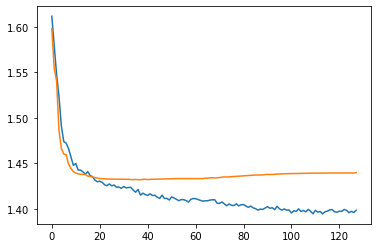

In [362]:
print(best_params)
plt.plot(best_model.log.to_pandas())

In [444]:
best_params_ = {'sigma': 0.3, 'num_nodes_shared': [64, 64], 'num_nodes_indiv': [32], 'lr': 0.001, 'dropout': 0.3, 'decoupled_weight_decay': 0.01, 'batch_size': 512, 'batch_norm': False, 'alpha': 0.2}

in_features = x_train_dh.shape[1]
num_nodes_shared = best_params_['num_nodes_shared']
num_nodes_indiv = best_params_['num_nodes_indiv']
num_risks = y_train_dh[1].max()
out_features = len(labtrans.cuts)
batch_norm = best_params_['batch_norm']
dropout = best_params_['dropout']


net = CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                       out_features, batch_norm, dropout)

lr_ = best_params_['lr']
dwd = best_params_['decoupled_weight_decay']
cem = 0.8
    
optimizer = tt.optim.AdamWR(lr=lr_, decoupled_weight_decay=dwd, cycle_eta_multiplier=cem)

model = DeepHit(net, optimizer, alpha=best_params_['alpha'], sigma=best_params_['sigma'], duration_index=labtrans.cuts)
    
epochs = 512
batch_size = best_params_['batch_size']
callbacks = [tt.callbacks.EarlyStoppingCycle()]
verbose = False
    
log = model.fit(x_train_dh, y_train_dh, batch_size, epochs, callbacks, verbose, val_data=val)
cif_dh = model.predict_cif(x_test_dh)

cif - трехмерный массив размера (96, 100, 4800), где

*   axis=0 - тип события, от 0 до 95 (используется только 8, zero_code -1 соотв.)
*   axis=1 - временная шкала
*   axis=2 - соответствующие наблюдения



In [364]:
def surv_func_1(cif, event_of_interest=1):
  return 1-(cif.transpose()[..., event_of_interest-1])

def surv_func_2(cif, event_of_interest=1):
  return 1 - (cif[df.event.unique()-1].sum(axis=0).T - (cif.transpose()[..., event_of_interest-1]))

def surv_func_3(cif, event_of_interest=1):
  return 1 - (cif.sum(axis=0).T - (cif.transpose()[..., event_of_interest-1]))

1. sf 1:  $$ S_k(t) = 1 - cif_k$$
1. sf 2:  $$ S_k(t) = 1 - \sum_{i!=k} cif_k, i\in (1, 2, 3, 9, 15, 16, 96)$$
1. sf 3:  $$ S_k(t) = 1 - \sum_{i=0, i!=k}^{95} cif_k$$

ibs 1 :   0.2249
ibs 9 :   0.2019
ibs 96:   0.2233
ibs 16:   0.0997
ibs 3 :   0.1916
ibs 2 :   0.1886
ibs 15:   0.1400
---------
 ibs: 0.4840


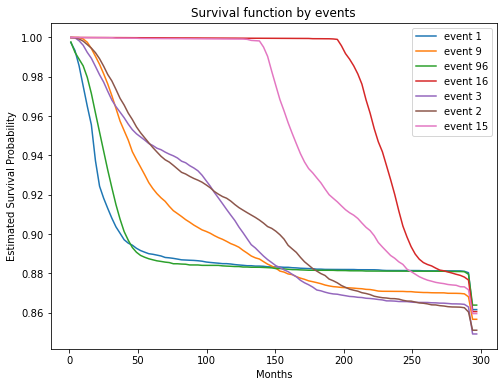

In [445]:
fig, axs = plt.subplots(figsize=(8, 6))
scores=[]
summ=np.empty(shape=model.duration_index.shape)
y_tmp = pd.DataFrame({'event': y_train_dh[1], 'duration': y_train_dh[0]})
#print('       до преобр.    после преобр.')
#print('        1-cif_k')
for i in df.event.unique():
  if i:

    sf1 = transform_timegrid(surv_func_1(cif_dh, dct[i]), model.duration_index, TIME_GRID)

    ibs_ = ibs_remain(get_y_event(y_tmp, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf1, times=TIME_GRID, axis=-1)

    print(f"ibs {i:<2}:   {ibs_:<4.4f}")
    axs.plot(TIME_GRID,
          sf1.mean(axis=0),
          label=f"event {i}")


est = transform_timegrid(cif.transpose()[..., sorted(y_train.event.unique())[:-1]].mean(axis=2),
              model.duration_index, TIME_GRID)

ibs_ = ibs_remain(get_y_event(y_tmp, sorted(df.event.unique())[1:]),
                  get_y_event(y_test, sorted(df.event.unique())[1:]),
                  est, TIME_GRID, axis=-1)

print('---------\n', f"ibs: {ibs_:.4f}")
# ibs['DeepHit']=scores
axs.legend()
axs.set_title(f"Survival function by events")
axs.set_xlabel("Months")
axs.set_ylabel("Estimated Survival Probability")

plt.show()

Здесь использовалось линейное преобразование  оси Y в [0, 1], т.к. cif_k <= 0.12 (+-) (т.к. $\sum_{k}cif_k + S(t) = 1$) (Аналогично в AalenJohansen, но там осталось 0.12)

---

ниже график S(t)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(model.duration_index,
          1-summ,
          label=f"survival_function")
ax.legend()
plt.show()

## CoxPH

[]

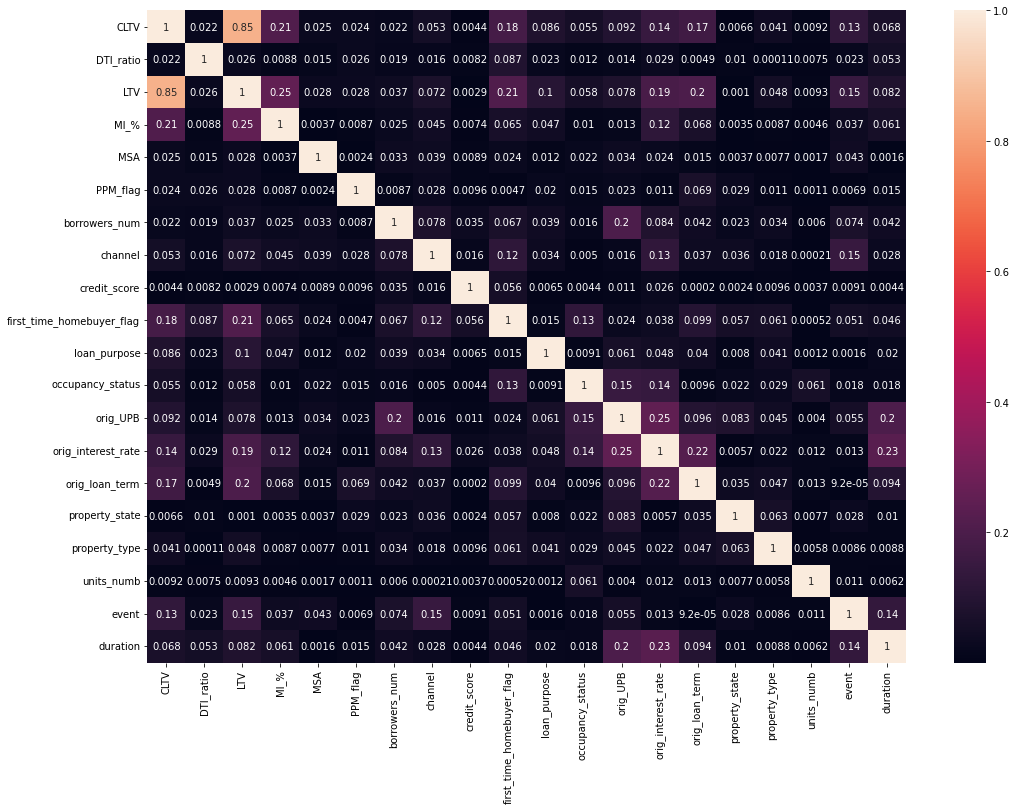

In [203]:
corr_matrix = x.corr().abs()
plt.figure(figsize=(17, 12))
sns.heatmap(corr_matrix, annot=True)
plt.plot()

### Подбор гиперпараметров

In [384]:
q = np.array([1, 2, 2, 4])
qq = np.array([1, 1, 2, 4])
print(sum(q<qq))

0


In [399]:
N = 20
param_grid = {
    'penalizer': np.logspace(-3, 2, N)
}

params = list(ParameterSampler(param_grid, n_iter=N, random_state=42))
x = x_train.join(y_train)

best_ibs = 10
best_params = None
best_model = None
events = df.event.unique()
olds = np.array([0.23, 0.20, 0.22, 0.14, 0.20, 0.19, 0.16])

for j, param in enumerate(params):
    tmp_ibs = np.empty(shape=(len(df.event.unique())-1, ))
    for i in events:
        if i:
            coxph = CoxPHFitter(penalizer=param['penalizer'])
            x_tmp = x.copy()
            x_tmp['event'] = x.event.isin([dct[i]]).astype('int')
            coxph.fit(x_tmp, duration_col='duration', event_col = 'event')
            sf = coxph.predict_survival_function(x_test, times=TIME_GRID)

            # ibs of model for current event and hyperparams

            ibs_ = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf.T,
                      times=TIME_GRID, axis=-1)
            tmp_ibs[dct[i]-1] = ibs_
    
    if (sum(tmp_ibs < best_ibs) > sum(tmp_ibs > best_ibs)) or (sum(tmp_ibs > olds) < sum(best_ibs > olds)): 
        # улучшение метрик по как можно большему числу событий
        # + чтобы в итоге все метрики оказались лучше того, что было в начале
            print('succ')
            best_ibs = tmp_ibs
            best_params = param
            best_model = coxph
        
print(best_ibs)
print(best_params)

succ
succ
[0.13689621 0.15429168 0.14252607 0.12563    0.05581295 0.05428058
 0.17203238]
{'penalizer': 0.02069138081114789}


### обучение моделей

           на себе+цензурированные      на себе     ранние цензурируются
ibs 1 :           0.1368                 0.5600           0.1251
ibs 9 :           0.1255                 0.4239           0.1436
ibs 96:           0.1719                 0.5937           0.1626
ibs 16:           0.0543                 0.0917           0.0540
ibs 3 :           0.1425                 0.3754           0.1357
ibs 2 :           0.1542                 0.3465           0.1407
ibs 15:           0.0558                 0.1372           0.0547


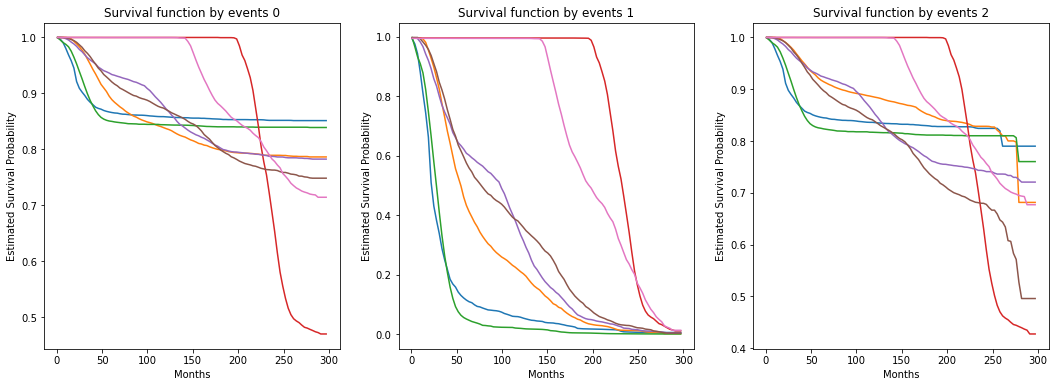

In [608]:
# constant_cols=['int_only_flag', 'property_val_method', 'super_conf_flag', 'amortization_type']
x = x_train.join(y_train)
print('           на себе+цензурированные      на себе     ранние цензурируются')
coxph = CoxPHFitter(penalizer=0.02)
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i in df.event.unique():
  if i:
     #-------------------------  1 ---------------------------------
        
    x_tmp = x.copy()
    x_tmp['event'] = x.event.isin([dct[i]]).astype('int')
    coxph.fit(x_tmp, duration_col='duration', event_col = 'event')
    sf = coxph.predict_survival_function(x_test, times=TIME_GRID)

    ibs_1 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf.T,
                      times=TIME_GRID, axis=-1)
    ax[0].plot(TIME_GRID,
                sf.mean(axis=1),
                label=f"event {i}")
    
    #-------------------------  2 ---------------------------------
    
    x_, y_ = case2(x_train, y_train, [dct[i]])
    x_ = x_.join(y_)
    x_['event'] = x_.event.astype('int')
    
    coxph.fit(x_, duration_col='duration', event_col = 'event')
    sf = coxph.predict_survival_function(x_test, times=TIME_GRID)

    ibs_2 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf.T,
                      times=TIME_GRID, axis=-1)
    ax[1].plot(TIME_GRID,
                sf.mean(axis=1),
                label=f"event {i}")
    
    #-------------------------  3 ---------------------------------
    
    x_, y_ = case3(x_train, y_train, [dct[i]])
    x_ = x_.join(y_)
    x_['event'] = x_.event.astype('int')
    
    coxph.fit(x_, duration_col='duration', event_col = 'event')
    sf = coxph.predict_survival_function(x_test, times=TIME_GRID)

    ibs_3 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf.T,
                      times=TIME_GRID, axis=-1)
    
    #--------------------------------------------------------------
    print(f"ibs {i:<2}:           {ibs_1:<4.4f}                 {ibs_2:<4.4f}           {ibs_3:<4.4f}")
    
    ax[2].plot(TIME_GRID,
                sf.mean(axis=1),
                label=f"event {i}")
for i in (0, 1, 2):
    ax[i].set_title(f"Survival function by events {i}")
    ax[i].set_xlabel("Months")
    ax[i].set_ylabel("Estimated Survival Probability")
plt.show()


## RSF

### Подбор гиперпараметров

In [403]:
N = 40
param_grid = {
    "n_estimators": [20, 50, 100, 300],
    "min_samples_split": [2, 6, 10], 
    "min_samples_leaf": [2, 4],
    "max_features": ["sqrt", "log2", None],
}

params = list(ParameterSampler(param_grid, n_iter=N, random_state=42))

best_ibs = 10
best_params = None
best_model = None

for j, param in enumerate(params):
    print(j)
    tmp_ibs = np.empty(shape=(len(df.event.unique())-1, ))
    for i in df.event.unique():
        if i:
            rsf = RandomSurvivalForest(random_state=42, 
                                       n_jobs=-1,
                                       n_estimators=param['n_estimators'],
                                       min_samples_split=param['min_samples_split'], 
                                       min_samples_leaf=param['min_samples_leaf'],
                                       max_depth = param['max_depth'],
                                       max_features = param['max_features']
                                      )
            y_tmp = y_train.copy()
            y_tmp['event'] = y_train.event.isin([dct[i]]).astype('int')

            rsf.fit(x_train, get_y_event(y_train, [dct[i]]))
            sf = rsf.predict_survival_function(x_test)
            sf, times = step_to_array(sf)
            sf = transform_timegrid(sf, times, TIME_GRID)
            # ibs of model for current event and hyperparams

            ibs_ = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf,
                      times=TIME_GRID, axis=-1)
            tmp_ibs[dct[i]-1] = ibs_
    
    if (sum(tmp_ibs < best_ibs) > sum(tmp_ibs > best_ibs)) or (sum(tmp_ibs > olds) < sum(best_ibs > olds)): 
        # улучшение метрик по как можно большему числу событий
        # + чтобы в итоге все метрики оказались лучше того, что было в начале
            best_ibs = tmp_ibs
            best_params = param
            best_model = coxph
        
print(best_ibs)
print(best_params)

succ
succ
succ
succ
succ
succ
[0.08934052 0.14434872 0.1308987  0.11195583 0.05499782 0.05209439
 0.14749165]
{'n_estimators': 365, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': None}


### обучение моделей

           на себе+цензурированные      на себе     ранние цензурируются
ibs 1 :           0.1017                 0.5847           0.1238
ibs 9 :           0.1196                 0.4506           0.1160
ibs 96:           0.1591                 0.5982           0.1491
ibs 16:           0.0516                 0.0929           0.0498
ibs 3 :           0.1343                 0.3795           0.1271
ibs 2 :           0.1486                 0.3634           0.1419
ibs 15:           0.0559                 0.1574           0.0550


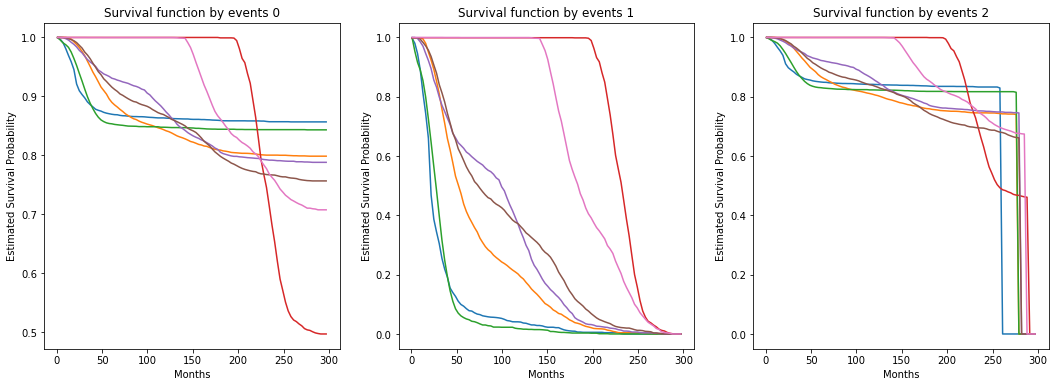

In [548]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
print('           на себе+цензурированные      на себе     ранние цензурируются')
rsf = RandomSurvivalForest(random_state=42, n_jobs=-1, n_estimators=350, min_samples_split=10, min_samples_leaf=4)
for i in df.event.unique():
  if i:
    
    #-------------------------  1 --------------------------------
    
    y_tmp = y_train.copy()
    y_tmp['event'] = y_train.event.isin([dct[i]]).astype('int')
    
    rsf.fit(x_train, get_y_event(y_train, [dct[i]]))
    sf = rsf.predict_survival_function(x_test)
    sf, times = step_to_array(sf)
    sf = transform_timegrid(sf, times, TIME_GRID)

    ibs_1 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf,
                      times=TIME_GRID, axis=-1)    
    ax[0].plot(TIME_GRID, sf.mean(axis=0), label=f"event {i}")
    
    #-------------------------  2 --------------------------------
    
    x_train_, y_train_ = case2(x_train, y_train, [dct[i]])
    y_train_['event'] = y_train_.event.astype('int')
    
    rsf.fit(x_train_, get_y_arr(y_train_))
    sf = rsf.predict_survival_function(x_test)
    sf, times = step_to_array(sf)
    sf = transform_timegrid(sf, times, TIME_GRID)

    ibs_2 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf,
                      times=TIME_GRID, axis=-1) 
    
    ax[1].plot(TIME_GRID, sf.mean(axis=0), label=f"event {i}")
    
    #-------------------------  3 --------------------------------
    
    x_train_, y_train_ = case3(x_train, y_train, [dct[i]])
    y_train_['event'] = y_train_.event.astype('int')
    
    rsf.fit(x_train_, get_y_arr(y_train_))
    sf = rsf.predict_survival_function(x_test)
    sf, times = step_to_array(sf)
    sf = transform_timegrid(sf, times, TIME_GRID)

    ibs_3 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf,
                      times=TIME_GRID, axis=-1) 
    
    ax[2].plot(TIME_GRID, sf.mean(axis=0), label=f"event {i}")
    #--------------------------------------------------------------
    print(f"ibs {i:<2}:           {ibs_1:<4.4f}                 {ibs_2:<4.4f}           {ibs_3:<4.4f}")
    
for i in (0, 1, 2):
    ax[i].set_title(f"Survival function by events {i}")
    ax[i].set_xlabel("Months")
    ax[i].set_ylabel("Estimated Survival Probability")
plt.show()

## GBSA

In [407]:
N = 40
param_dist = {
    "n_estimators":[50, 100, 200, 400],
    "learning_rate": np.logspace(-3, 0, 10),
    "max_depth": [3, 5, 7, 10],
    "subsample": np.linspace(0.5, 1.0, 5),
}

params = list(ParameterSampler(param_grid, n_iter=N, random_state=42))

best_ibs = 10
best_params = None
best_model = None

for j, param in enumerate(params):
    print(j)
    tmp_ibs = np.empty(shape=(len(df.event.unique())-1, ))
    for i in df.event.unique():
        if i:
            gbsa = GradientBoostingSurvivalAnalysis(random_state=42)
            y_tmp = y_train.copy()
            y_tmp['event'] = y_train.event.isin([dct[i]]).astype('int')

            gbsa.fit(x_train, get_y_event(y_train, [dct[i]]))
            sf = gbsa.predict_survival_function(x_test)
            sf, times = step_to_array(sf)
            sf = transform_timegrid(sf, times, TIME_GRID)
                # ibs of model for current event and hyperparams

            ibs_ = ibs_remain(get_y_event(y_train, [dct[i]]),
                        get_y_event(y_test, [dct[i]]),
                        sf,
                        times=TIME_GRID, axis=-1)
            tmp_ibs[dct[i]-1] = ibs_
    
    if (sum(tmp_ibs < best_ibs) > sum(tmp_ibs > best_ibs)) or (sum(tmp_ibs > olds) < sum(best_ibs > olds)): 
        # улучшение метрик по как можно большему числу событий
        # + чтобы в итоге все метрики оказались лучше того, что было в начале
            best_ibs = tmp_ibs
            best_params = param
            best_model = coxph
        
print(best_ibs)
print(best_params)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
[0.12105186 0.15817511 0.15305534 0.13073905 0.06017743 0.05394901
 0.01535475]
{'n_estimators': 470, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}


           на себе+цензурированные      на себе     ранние цензурируются
ibs 1 :           0.1211                 0.5641           0.1312
ibs 9 :           0.1307                 0.4463           0.1208
ibs 96:           0.1753                 0.6057           0.1599
ibs 16:           0.0539                 0.0931           0.0518
ibs 3 :           0.1531                 0.3878           0.1390
ibs 2 :           0.1582                 0.3685           0.1445
ibs 15:           0.0602                 0.1478           0.0590


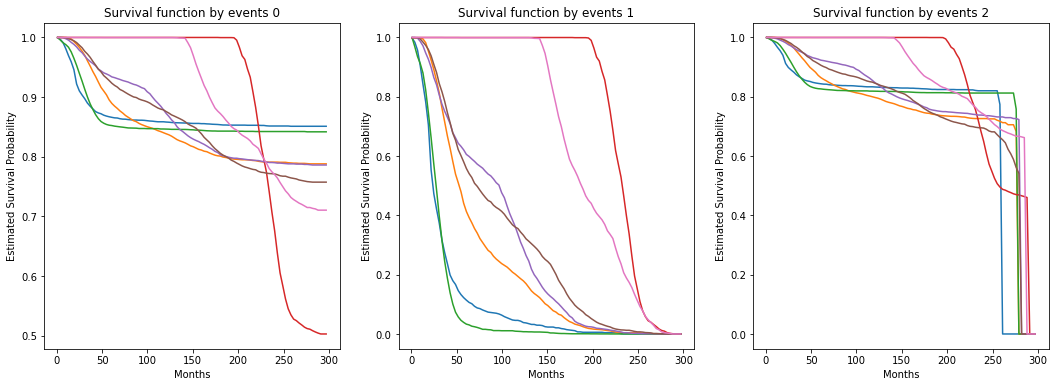

In [549]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
print('           на себе+цензурированные      на себе     ранние цензурируются')
gbsa = GradientBoostingSurvivalAnalysis(random_state=42)
for i in df.event.unique():
  if i:
    #-------------------------  1 --------------------------------
    #gbsa = GradientBoostingSurvivalAnalysis(random_state=42)# min_samples_split=5, min_samples_leaf=2, max_features='log2')
    y_tmp = y_train.copy()
    y_tmp['event'] = y_train.event.isin([dct[i]]).astype('int')
    
    gbsa.fit(x_train, get_y_event(y_train, [dct[i]]))
    sf = gbsa.predict_survival_function(x_test)
    sf, times = step_to_array(sf)
    sf = transform_timegrid(sf, times, TIME_GRID)
    
    ibs_1 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf,
                      times=TIME_GRID, axis=-1)
    ax[0].plot(TIME_GRID,
                sf.mean(axis=0),
                label=f"event {i}")
    
    #-------------------------  2 --------------------------------
    x_train_, y_train_ = case2(x_train, y_train, [dct[i]])
    y_train_['event'] = y_train_.event.astype('int')
    
    gbsa.fit(x_train_, get_y_arr(y_train_))
    sf = gbsa.predict_survival_function(x_test)
    sf, times = step_to_array(sf)
    sf = transform_timegrid(sf, times, TIME_GRID)

    ibs_2 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf,
                      times=TIME_GRID, axis=-1)
    
    ax[1].plot(TIME_GRID, sf.mean(axis=0), label=f"event {i}")
    
    #-------------------------  3 --------------------------------
    
    x_train_, y_train_ = case3(x_train, y_train, [dct[i]])
    y_train_['event'] = y_train_.event.astype('int')
    
    gbsa.fit(x_train_, get_y_arr(y_train_))
    sf = gbsa.predict_survival_function(x_test)
    sf, times = step_to_array(sf)
    sf = transform_timegrid(sf, times, TIME_GRID)
    
    ibs_3 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf,
                      times=TIME_GRID, axis=-1)
    
    ax[2].plot(TIME_GRID, sf.mean(axis=0), label=f"event {i}")
    #--------------------------------------------------------------
    print(f"ibs {i:<2}:           {ibs_1:<4.4f}                 {ibs_2:<4.4f}           {ibs_3:<4.4f}")
    
for i in (0, 1, 2):
    ax[i].set_title(f"Survival function by events {i}")
    ax[i].set_xlabel("Months")
    ax[i].set_ylabel("Estimated Survival Probability")
plt.show()
# ibs 1 :   0.12
# ibs 9 :   0.13
# ibs 96:   0.18
# ibs 16:   0.05
# ibs 3 :   0.15
# ibs 2 :   0.16
# ibs 15:   0.06

## Класс-обертка для ovr моделей

In [10]:
class OvR:
    def __init__(self, estimator, mode, early_threshold=1.0):
        self.estimator = estimator
        self.mode = mode
        self.y_train=None
        self.models = None
        self.events = None
        self.TIME_GRID = None
        self.thrsh = early_threshold
    
    def step_to_array(self, step_functions):
        shape_=(step_functions.shape[0], step_functions[0].x.shape[0])
        arr = np.empty(shape=shape_)
        for i in range(len(step_functions)):
            arr[i] = step_functions[i].y
        return arr, step_functions[0].x
    
    def transform_timegrid(self, curves, time, grid):
        if time.max() < grid.max():
            time = np.hstack([time, np.array([grid.max()+1])])
            if len(curves.shape)==1:
                curves = np.hstack([curves, np.array([0])])
            elif len(curves.shape)==2:
                curves = np.hstack([curves, np.zeros(shape=(curves.shape[0], 1))])
        ind = np.searchsorted(time, grid)
        if len(curves.shape)==1:
            return curves[ind]
        elif len(curves.shape)==2:
            return curves[:, ind]
        else:
            return None
    
    def transform_xy(self, X, y, events: List=[]):
        if self.mode == 'all':
            X, y = self.case1(X, y, events)
        elif self.mode == 'single':
            X, y = self.case2(X, y, events)
        elif self.mode == 'early':
            X, y = self.case3(X, y, events, early_threshold=self.thrsh)
        else:
            raise ValueError('Wrong mode')
        return X, y
    
    def case1(self, X_, y_, events: List=[]):
        y, X = y_.copy(), X_.copy()
        mask = y_.event.isin(events)
        y.event = mask.astype('int')
        return X, y

    def case2(self, X_, y_, events: List=[]):
        y, X = y_.copy(), X_.copy()
        mask = y_.event.isin(events)
        y.event = mask
        y = y[mask]
        X = X[mask]
        y.event = y.event.astype('int')
        return X, y

    def case3(self, X_, y_, events: List=[], early_threshold=1.0):
        y, X = y_.copy(), X_.copy()
        mask = y_.event.isin(events)
        maxm = y_.duration[mask].quantile(early_threshold)
        y.event = mask
        X = X[y.duration<=maxm]
        y = y[y.duration<=maxm]
        y.event = y.event.astype('int')
        return X, y
    
    def fit(self, X_, y_):
        self.TIME_GRID = np.linspace(y_['duration'].min(), y_['duration'].max(), 100)
        self.model = []
        self.events = y_.event.unique()
        self.y_train = y_
        for i in sorted(self.events):
            if i:
                tmp = copy.deepcopy(self.estimator)
                X, y = self.transform_xy(X_, y_, [i])
                if type(self.estimator) == CoxPHFitter:
                    X = X.join(y)
                    tmp.fit(X, duration_col='duration', event_col = 'event')
                else:
                    y = get_y_arr(y)
                    tmp.fit(X, y)
                self.model.append(tmp)
    
    def predict(self, X_):
        predictions = np.empty(shape=(len(self.events)-1, X_.shape[0], 100))
        for i in sorted(self.events):
            if i:
                if type(self.estimator) == CoxPHFitter:
                    sf = (self.model[i-1].predict_survival_function(X_, times=TIME_GRID)).T
                else:
                    sf = self.model[i-1].predict_survival_function(X_)
                    sf, times = step_to_array(sf)
                    sf = transform_timegrid(sf, times, TIME_GRID)
                predictions[i-1]=sf
        return predictions
                
            

### пример работы

In [11]:
from sksurv.ensemble import RandomSurvivalForest

In [28]:
def get_y_self_event(y_, events: List=[]):
    l = sum(y_.event.isin(events))
    y = np.empty(dtype=[('event', bool), ('duration', np.float64)], shape=l)
    y["duration"] = y_[y_.event.isin(events)]["duration"]
    y["event"] = 1
    return y

# get_y_self_event(y_train, [1])

In [45]:
early_threshold=0.75

c = RandomSurvivalForest(random_state=42, n_jobs=-1, n_estimators=50, min_samples_split=10, min_samples_leaf=4)
e = OvR(c, mode='early', early_threshold=early_threshold)
e.fit(x_train, y_train)
pred = e.predict(x_test)

print(f"Early threshold {early_threshold}")
for i in df.event.unique():
    if i:
        sf = pred[dct[i]-1]
        ibs_self = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      sf[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
        ibs = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf,
                      times=TIME_GRID, axis=-1)
        print(f"Event {i}")
        print(f'ibs self {i}: {ibs_self:<4.4f}')
        print(f'ibs all (other sens) {i}: {ibs:<4.4f}')
        print()


# для early_threshold=1.0
# ibs 1: 0.1238
# ibs 9: 0.1160
# ibs 96: 0.1491
# ibs 16: 0.0498
# ibs 3: 0.1271
# ibs 2: 0.1419
# ibs 15: 0.0550

Early threshold 0.75
Event 1
ibs self 1: 0.0343
ibs all (other sens) 1: 0.6381

Event 9
ibs self 9: 0.1023
ibs all (other sens) 9: 0.4936

Event 96
ibs self 96: 0.0335
ibs all (other sens) 96: 0.6162

Event 16
ibs self 16: 0.0358
ibs all (other sens) 16: 0.1087

Event 3
ibs self 3: 0.1120
ibs all (other sens) 3: 0.4037

Event 2
ibs self 2: 0.1373
ibs all (other sens) 2: 0.3459

Event 15
ibs self 15: 0.0618
ibs all (other sens) 15: 0.1758



## IBS

In [14]:
from sksurv.metrics import check_y_survival

def ibs_remain(survival_train, survival_test, estimate, times, axis=-1):
    """ IBS with equal impact of partial observation with controlled quantity """
    test_event, test_time = check_y_survival(survival_test, allow_all_censored=True)
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0

    estim_before = np.square(estimate) * test_event[np.newaxis, :].T
    estim_after = np.square(1 - estimate)
    brier_scores = np.array([np.where(test_time < t,
                                      estim_before[:, i],
                                      estim_after[:, i])
                             for i, t in enumerate(times)])
    N = np.sum(np.array([np.where(test_time < t, test_event, 1)
                         for i, t in enumerate(times)]), axis=1)
    time_diff = times[-1] - times[0] if times[-1] > times[0] else 1
    if axis == -1:  # mean ibs for each time and observation
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1 / N, 0) * np.sum(brier_scores, axis=1)
        return np.trapz(brier_scores, times) / time_diff
    elif axis == 0:  # ibs for each observation
        return np.trapz(brier_scores, times, axis=0) / time_diff
    elif axis == 1:  # bs in time (for graphics)
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1 / N, 0) * np.sum(brier_scores, axis=1)
        return brier_scores
    return None